In [ ]:
# load data
import gdown
gdown.download('https://drive.google.com/uc?id=1ojPUqKCCFxzoP4nzAOhpUbCH2Yj3mTg9', 'Asthma_dataset_norm_whz.zip', quiet=False)

!rm -rf 'norm'
!rm -rf 'whz'
!unzip -q 'Asthma_dataset_norm_whz.zip'
!rm -rf 'Asthma_dataset_norm_whz.zip'

Downloading...
From: https://drive.google.com/uc?id=1ojPUqKCCFxzoP4nzAOhpUbCH2Yj3mTg9
To: /content/Asthma_dataset_norm_whz.zip
100%|██████████| 2.47M/2.47M [00:00<00:00, 171MB/s]


In [ ]:
# create dataset, shuffle, split to train/valid, save to plain ndarray
#
# note1: naive train/valid splitting (!), 
#        if many samples from same subject it will be occure in both sets, 
#        this situation could lead to overfitting (!)
#
# note2: unknown resampling quality (librosa)
# 
# note3: normalize len: crop middle part if too long, append zeros to the end if too short
#
# note4: dataset is imbalanced
import os
import librosa


def load_waves(directory, filenames, cls, dataset, out_size):    
    for filename in filenames:
        try:
            data = librosa.load(os.path.join(directory, filename), sr=8000)
            data = data[0]
            if data.ndim != 1:
                print(f'Skipping NOT mono file: {filename}')
                continue
            data_len = len(data)
            if data_len > out_size:
                new_start_pos = int((data_len - out_size) / 2)
                data = data[new_start_pos:out_size+new_start_pos]
            elif data_len < out_size:
                data = np.append(data, np.zeros(out_size-data_len))
            dataset.append([data, cls, filename])
        except Exception as e:
            print(f'Skipping wrong file: {filename}')

positive_class = 'whz'
negative_class = 'norm'
filenames_pos = os.listdir(positive_class)
filenames_neg = os.listdir(negative_class)

dataset = list()
load_waves(positive_class, filenames_pos, 1, dataset, 2048)
load_waves(negative_class, filenames_neg, 0, dataset, 2048)

Skipping wrong file: whz5.wav
Skipping wrong file: whz126.wav
Skipping wrong file: whz6.wav
dataset len: 376


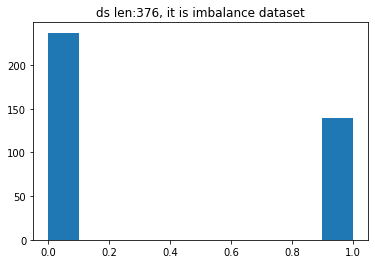

In [ ]:
# shuffle, split to train/valid dataset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X_dataset = np.vstack([data[0] for data in dataset])
y_dataset = np.array([data[1] for data in dataset])

x_train, x_valid, y_train, y_valid = train_test_split(X_dataset, y_dataset, test_size=0.2, 
                                                      shuffle=True, random_state=42)

plt.hist(y_dataset)
plt.title(f'ds len:{len(dataset)}, it is imbalance dataset')
plt.show()

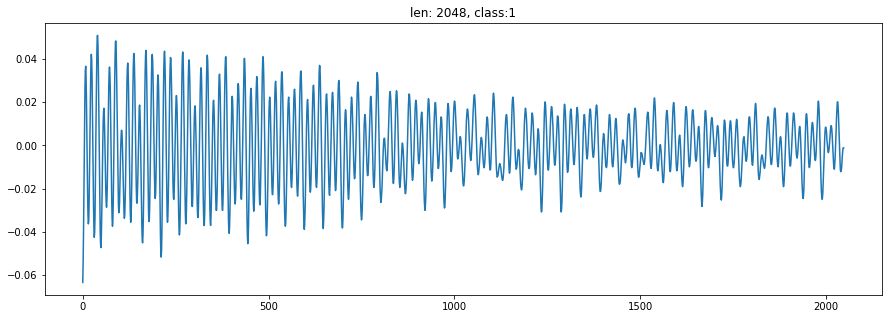

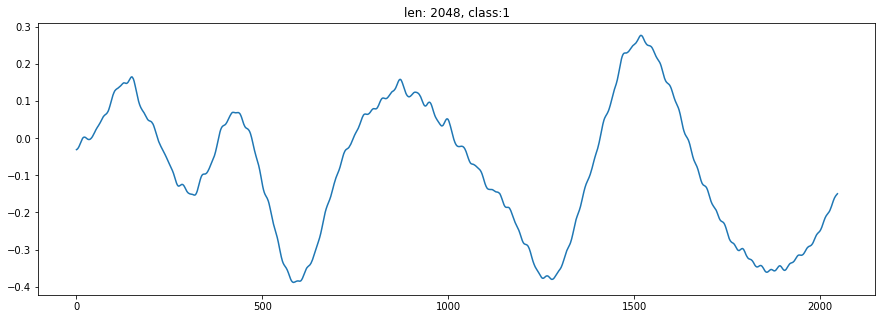

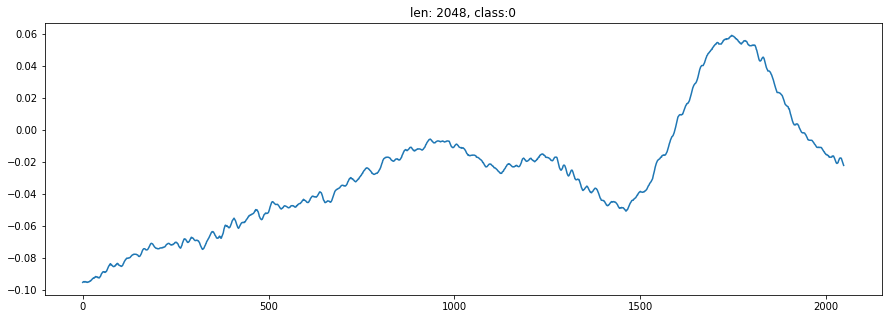

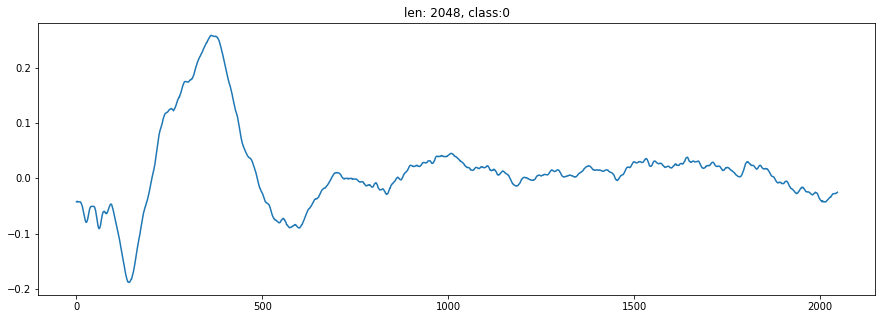

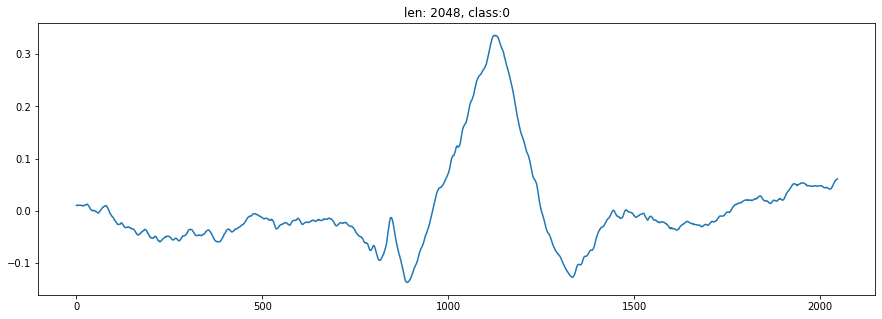

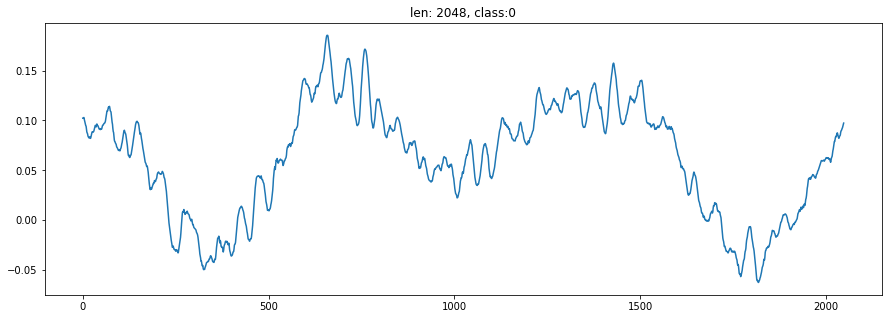

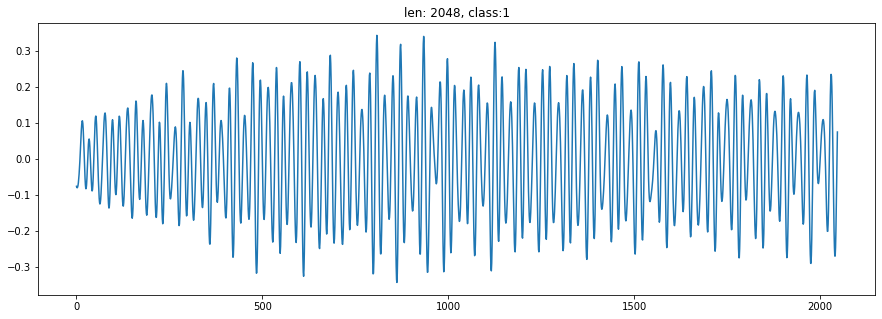

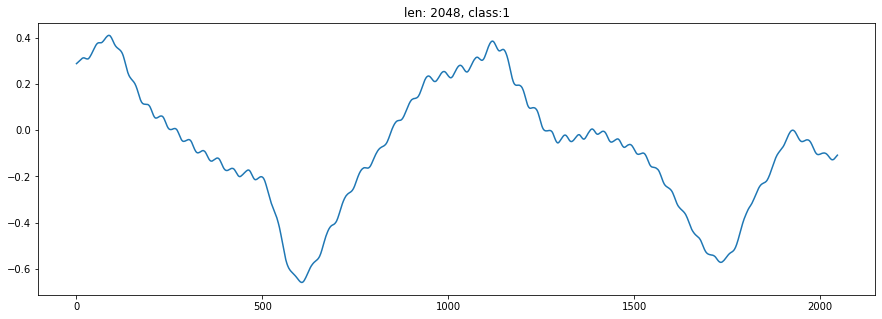

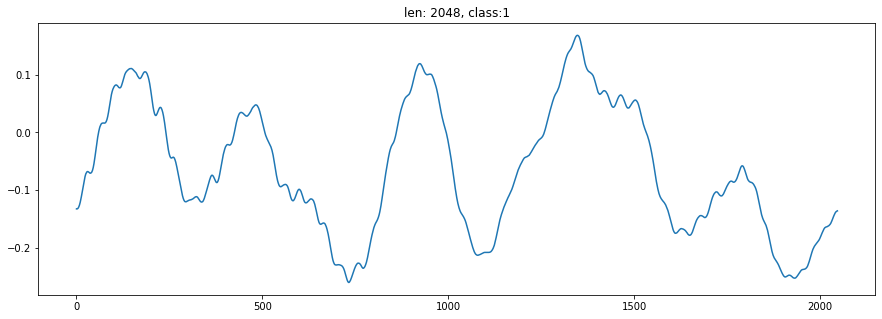

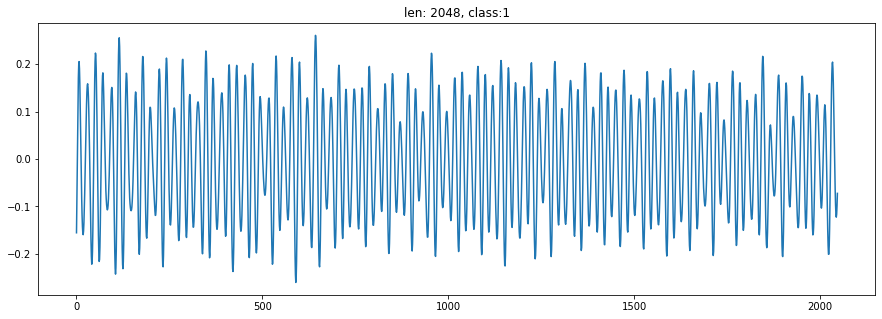

In [ ]:
# visualize 10 random samples from the training dataset
import random
import matplotlib.pyplot as plt

def plot_10_examples(X, y):
    for idx in random.sample(range(X.shape[0]), 10):
        plt.figure(figsize=(15, 5))
        plt.plot(X[idx])
        plt.title(f'len: {len(X[idx])}, class:{y[idx]}')
        plt.show()

plot_10_examples(x_train, y_train)

In [ ]:
# bulild a model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization
from sklearn.utils import class_weight
import tensorflow as tf

model = tf.keras.Sequential()
model.add(Conv1D(32, 11, input_shape=(2048, 1), activation='relu', name='L1'))
model.add(MaxPooling1D(4, name='P1'))
model.add(Dropout(0.3))
model.add(Conv1D(32, 11, activation='relu', name='L2'))
model.add(MaxPooling1D(4, name='P2'))
model.add(Dropout(0.3))
model.add(Conv1D(64, 11, activation='relu', name='L3'))
model.add(MaxPooling1D(4, name='P3'))
model.add(Dropout(0.3))
model.add(Conv1D(64, 11, activation='relu', name='L4'))
model.add(MaxPooling1D(4, name='P4'))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()
# tf.compat.v2.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L1 (Conv1D)                 (None, 2038, 32)          384       
                                                                 
 P1 (MaxPooling1D)           (None, 509, 32)           0         
                                                                 
 dropout_115 (Dropout)       (None, 509, 32)           0         
                                                                 
 L2 (Conv1D)                 (None, 499, 32)           11296     
                                                                 
 P2 (MaxPooling1D)           (None, 124, 32)           0         
                                                                 
 dropout_116 (Dropout)       (None, 124, 32)           0         
                                                                 
 L3 (Conv1D)                 (None, 114, 64)         

In [ ]:
history = model.fit(x_train, y_train, batch_size=16, epochs=30, 
                    class_weight={0:0.3, 1:0.7},
                    validation_data=(x_valid, y_valid))

Epoch 1/30
19/19 [==============================] - 2s 74ms/step - loss: 0.3017 - accuracy: 0.3567 - val_loss: 0.6865 - val_accuracy: 0.3947
Epoch 2/30
19/19 [==============================] - 1s 60ms/step - loss: 0.2806 - accuracy: 0.3667 - val_loss: 0.6384 - val_accuracy: 0.6711
Epoch 3/30
19/19 [==============================] - 1s 62ms/step - loss: 0.2607 - accuracy: 0.5900 - val_loss: 0.6447 - val_accuracy: 0.7105
Epoch 4/30
19/19 [==============================] - 1s 60ms/step - loss: 0.2597 - accuracy: 0.6467 - val_loss: 0.6215 - val_accuracy: 0.7368
Epoch 5/30
19/19 [==============================] - 1s 59ms/step - loss: 0.2549 - accuracy: 0.7000 - val_loss: 0.6145 - val_accuracy: 0.7632
Epoch 6/30
19/19 [==============================] - 1s 61ms/step - loss: 0.2473 - accuracy: 0.7167 - val_loss: 0.5971 - val_accuracy: 0.7500
Epoch 7/30
19/19 [==============================] - 1s 60ms/step - loss: 0.2507 - accuracy: 0.7567 - val_loss: 0.5902 - val_accuracy: 0.7368
Epoch 8/30
19

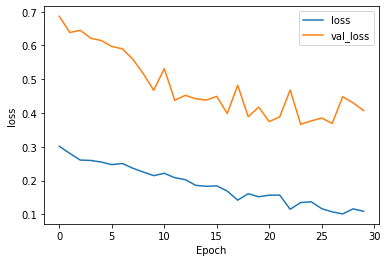

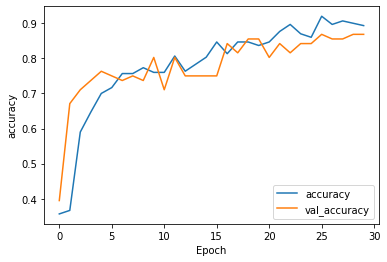

In [ ]:
# plot loss acuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.show()

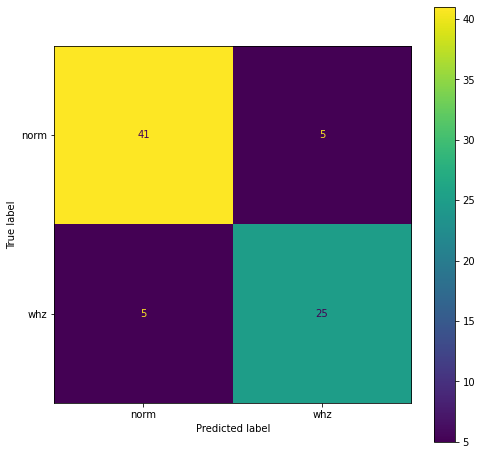

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(x_valid)>0.5

cm = confusion_matrix(y_valid, y_pred)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['norm', 'whz'])
fig, ax = plt.subplots(figsize=(8, 8))
cmp.plot(ax=ax)
fig.show()